In [1]:
import struct
import copy

import rospy
import gazebo_msgs.srv
import geometry_msgs.msg
import std_msgs.msg
import baxter_core_msgs.srv

import tf.transformations
import baxter_interface

import numpy as np
from utils import *
from baxter_pickplace_interface import *
from matplotlib import pyplot as plt
%matplotlib inline

### Init Node

In [2]:
rospy.init_node("ik_pick_and_place_demo")

### Connect robot

In [3]:
limb = "left"
hover_distance = 0.12
pnp = PickAndPlace(limb, hover_distance)
pnp.move_to_start()

Getting robot state... 
Enabling robot... 
[INFO] [1566265532.523592, 326.321000]: Robot Enabled
Moving the left arm to start pose...
Running. Ctrl-c to quit


### Spawn the environment

In [5]:
rospy.wait_for_service('/gazebo/spawn_sdf_model')
rospy.wait_for_service('/gazebo/spawn_urdf_model')
spawn_sdf = rospy.ServiceProxy('/gazebo/spawn_sdf_model', gazebo_msgs.srv.SpawnModel)
spawn_urdf = rospy.ServiceProxy('/gazebo/spawn_urdf_model', gazebo_msgs.srv.SpawnModel)

camera_quaternion = tf.transformations.quaternion_from_euler(0., np.pi / 2., 0.)
spawn_gazebo_model(spawn_urdf, "realsense", "rs200", 0.65, 0.0, 0.7825+0.7, 
                   qx=camera_quaternion[0],qy=camera_quaternion[1],qz=camera_quaternion[2],qw=camera_quaternion[3])
spawn_gazebo_model(spawn_sdf, "cafe_table", "cafe_table", 0.8, 0.0, 0.0)
# spawn_gazebo_model(spawn_sdf, "basket", "start_box", 0.65, 0.0, 0.7825)

number_of_object=1
for i in range(number_of_object):
    rnd_x = 0.01*(2.*np.random.uniform()-1.) + 0.65
    rnd_y = 0.01*(2.*np.random.uniform()-1.)
    rnd_z = 1.0
    rnd_roll = 2.*np.pi*np.random.uniform()
    rnd_pitch = 2.*np.pi*np.random.uniform()
    rnd_ywa = 2.*np.pi*np.random.uniform()
    rnd_quaternion = tf.transformations.quaternion_from_euler(rnd_roll,rnd_pitch,rnd_ywa)
    spawn_gazebo_model(spawn_sdf, "t_shape", "object"+str(i), 
                       rnd_x, rnd_y, rnd_z,
                       rnd_quaternion[0],rnd_quaternion[1],rnd_quaternion[2],rnd_quaternion[3])

### Move robot arm to starting pose

In [6]:
pnp.move_to_start()

Moving the left arm to start pose...
Running. Ctrl-c to quit


### Get RGBD image test

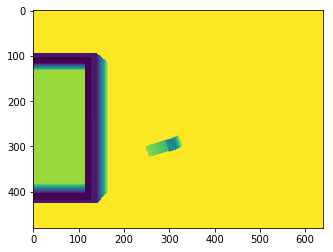

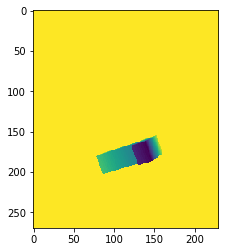

In [7]:
observation = get_rgbd_image()

# cropping parameter for cam height 1.0
cx = 285
cy = 255
wx = 115
wy = 135

color_data = observation["color"][cy-wy:cy+wy,cx-wx:cx+wx,:]
depth_data = np.float32(observation["depth"][cy-wy:cy+wy,cx-wx:cx+wx])*0.001

from matplotlib import pyplot as plt
%matplotlib inline
plt.figure()
plt.imshow(observation["depth"])
plt.figure()
plt.imshow(depth_data)
plt.show()

### Call FCGQCNN

/home/dof6/catkin_ws/src/grasp_adaptation/scripts/grasp_experts/cfg/examples/gqcnn_pj.yaml
/home/dof6/catkin_ws/src/grasp_adaptation/scripts/grasp_experts/models/GQCNN-4.0-PJ
GQCNNModelFactory INFO     Initializing GQ-CNN with Tensorflow as backend...
GQCNNTF    INFO     Building Network...
GQCNNTF    INFO     Building Image Stream...
GQCNNTF    INFO     Building convolutional layer: conv1_1...
GQCNNTF    INFO     Building convolutional layer: conv1_2...
GQCNNTF    INFO     Building convolutional layer: conv2_1...
GQCNNTF    INFO     Building convolutional layer: conv2_2...
GQCNNTF    INFO     Building fully connected layer: fc3...
GQCNNTF    INFO     Building Pose Stream...
GQCNNTF    INFO     Building Fully Connected Pose Layer: pc1...
GQCNNTF    INFO     Building Merge Stream...
GQCNNTF    INFO     Building Merge Layer: fc4...
GQCNNTF    INFO     Building fully connected layer: fc5...
GQCNNTF    INFO     Building Softmax Layer...
GQCNNTF    INFO     Initializing TF Session...
GQCNNT

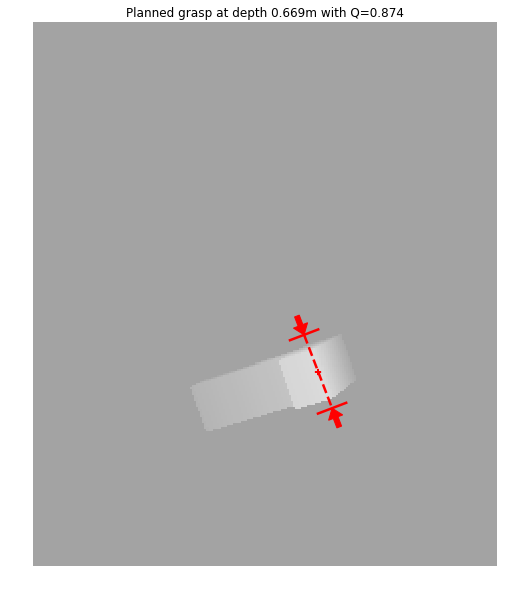

In [24]:
import json
import os
import time

import numpy as np

from autolab_core import YamlConfig, Logger
from perception import (BinaryImage, CameraIntrinsics, ColorImage, DepthImage,
                        RgbdImage)
from visualization import Visualizer2D as vis

from gqcnn.grasping import (RobustGraspingPolicy,
                            CrossEntropyRobustGraspingPolicy, RgbdImageState,
                            FullyConvolutionalGraspingPolicyParallelJaw,
                            FullyConvolutionalGraspingPolicySuction)
from gqcnn.utils import GripperMode

# model_name = 'FC-GQCNN-4.0-PJ'
# config_filename = None
# fully_conv = True

model_name = 'GQCNN-4.0-PJ'
config_filename = None
fully_conv = False

# model_name = 'GQCNN-2.0'
# config_filename = 'scripts/grasp_experts/cfg/examples/replication/dex-net_2.0.yaml'
# fully_conv = False

# model_name = 'GQCNN-2.1'
# config_filename = 'scripts/grasp_experts/cfg/examples/replication/dex-net_2.1.yaml'
# fully_conv = False

# model_name = 'GQCNN-3.0'
# config_filename = 'scripts/grasp_experts/cfg/examples/replication/dex-net_3.0.yaml'
# fully_conv = False

depth_im_filename = None
segmask_filename = None
camera_intr_filename = None
model_dir = None
__file__ = os.path.abspath('')

assert not (fully_conv and depth_im_filename is not None
            and segmask_filename is None
            ), "Fully-Convolutional policy expects a segmask."

if camera_intr_filename is None:
    camera_intr_filename = os.path.join(os.path.dirname(os.path.realpath(__file__)),
                                        "scripts/grasp_experts/data/calib/primesense/primesense.intr")

# Set model if provided.
if model_dir is None:
    model_dir = os.path.join(os.path.dirname(os.path.realpath(__file__)),
                             "scripts/grasp_experts/models")
model_path = os.path.join(model_dir, model_name)

# Get configs.
model_config = json.load(open(os.path.join(model_path, "config.json"), "r"))
try:
    gqcnn_config = model_config["gqcnn"]
    gripper_mode = gqcnn_config["gripper_mode"]
except KeyError:
    gqcnn_config = model_config["gqcnn_config"]
    input_data_mode = gqcnn_config["input_data_mode"]
    if input_data_mode == "tf_image":
        gripper_mode = GripperMode.LEGACY_PARALLEL_JAW
    elif input_data_mode == "tf_image_suction":
        gripper_mode = GripperMode.LEGACY_SUCTION
    elif input_data_mode == "suction":
        gripper_mode = GripperMode.SUCTION
    elif input_data_mode == "multi_suction":
        gripper_mode = GripperMode.MULTI_SUCTION
    elif input_data_mode == "parallel_jaw":
        gripper_mode = GripperMode.PARALLEL_JAW
    else:
        raise ValueError(
            "Input data mode {} not supported!".format(input_data_mode))
        
# Set config.
if config_filename is None:
    if (gripper_mode == GripperMode.LEGACY_PARALLEL_JAW
            or gripper_mode == GripperMode.PARALLEL_JAW):
        if fully_conv:
            config_filename = os.path.join(
                os.path.dirname(os.path.realpath(__file__)), "scripts/grasp_experts/cfg/examples/fc_gqcnn_pj.yaml")
        else:
            config_filename = os.path.join(
                os.path.dirname(os.path.realpath(__file__)), "scripts/grasp_experts/cfg/examples/gqcnn_pj.yaml")
    elif (gripper_mode == GripperMode.LEGACY_SUCTION
          or gripper_mode == GripperMode.SUCTION):
        if fully_conv:
            config_filename = os.path.join(
                os.path.dirname(os.path.realpath(__file__)), "scripts/grasp_experts/cfg/examples/fc_gqcnn_suction.yaml")
        else:
            config_filename = os.path.join(
                os.path.dirname(os.path.realpath(__file__)), "scripts/grasp_experts/cfg/examples/gqcnn_suction.yaml")
else:
    config_filename = os.path.join(
                os.path.dirname(os.path.realpath(__file__)), config_filename)
print(config_filename)
    
# Read config.
config = YamlConfig(config_filename)
inpaint_rescale_factor = config["inpaint_rescale_factor"]
policy_config = config["policy"]

# Make relative paths absolute.
if "gqcnn_model" in policy_config["metric"]:
    policy_config["metric"]["gqcnn_model"] = model_path
    if not os.path.isabs(policy_config["metric"]["gqcnn_model"]):
        policy_config["metric"]["gqcnn_model"] = os.path.join(
            os.path.dirname(os.path.realpath(__file__)), "..",
            policy_config["metric"]["gqcnn_model"])

# Setup sensor.
camera_intr = CameraIntrinsics.load(camera_intr_filename)

# Read images.
depth_im = DepthImage(depth_data, frame=camera_intr.frame)
color_im = ColorImage(color_data, frame=camera_intr.frame)

# Optionally read a segmask.
segmask = None
if segmask_filename is not None:
    segmask = BinaryImage.open(segmask_filename)
valid_px_mask = depth_im.invalid_pixel_mask().inverse()
if segmask is None:
    segmask = valid_px_mask
else:
    segmask = segmask.mask_binary(valid_px_mask)

# Inpaint.
depth_im = depth_im.inpaint(rescale_factor=inpaint_rescale_factor)

if "input_images" in policy_config["vis"] and policy_config["vis"][
        "input_images"]:
    vis.figure(size=(10, 10))
    num_plot = 1
    if segmask is not None:
        num_plot = 2
    vis.subplot(1, num_plot, 1)
    vis.imshow(depth_im)
    if segmask is not None:
        vis.subplot(1, num_plot, 2)
        vis.imshow(segmask)
    vis.show()

# Create state.
rgbd_im = RgbdImage.from_color_and_depth(color_im, depth_im)
state = RgbdImageState(rgbd_im, camera_intr, segmask=segmask)

# Set input sizes for fully-convolutional policy.
if fully_conv:
    policy_config["metric"]["fully_conv_gqcnn_config"][
        "im_height"] = depth_im.shape[0]
    policy_config["metric"]["fully_conv_gqcnn_config"][
        "im_width"] = depth_im.shape[1]

# Init policy.
if fully_conv:
    # TODO(vsatish): We should really be doing this in some factory policy.
    if policy_config["type"] == "fully_conv_suction":
        policy = FullyConvolutionalGraspingPolicySuction(policy_config)
    elif policy_config["type"] == "fully_conv_pj":
        policy = FullyConvolutionalGraspingPolicyParallelJaw(policy_config)
    else:
        raise ValueError(
            "Invalid fully-convolutional policy type: {}".format(
                policy_config["type"]))
else:
    policy_type = "cem"
    if "type" in policy_config:
        policy_type = policy_config["type"]
    if policy_type == "ranking":
        policy = RobustGraspingPolicy(policy_config)
    elif policy_type == "cem":
        policy = CrossEntropyRobustGraspingPolicy(policy_config)
    else:
        raise ValueError("Invalid policy type: {}".format(policy_type))

# Query policy.
policy_start = time.time()
actions, q_values = policy.action_set(state)
# print(actions)
print(q_values)
idx = np.argmax(q_values)
q_value = q_values[idx]
action = actions[idx]
rospy.loginfo("Planning took %.3f sec" % (time.time() - policy_start))

# Vis final grasp.
if policy_config["vis"]["final_grasp"]:
    vis.figure(size=(10, 10))
    depth_im = DepthImage(depth_data - 0.1, frame=camera_intr.frame)
    vis.imshow(depth_im,
               vmin=policy_config["vis"]["vmin"],
               vmax=policy_config["vis"]["vmax"])
    vis.grasp(action, scale=2.5, show_center=True, show_axis=True)
    vis.title("Planned grasp at depth {0:.3f}m with Q={1:.3f}".format(
        action.depth, q_value))
    vis.show()

### Transform frame (camera $\rightarrow$ robot)

In [42]:
from copy import deepcopy
import tf.transformations

depth_cam_rotation_matrix = np.zeros([4,4])
depth_cam_rotation_matrix[1,0] = -1.
depth_cam_rotation_matrix[0,1] = -1.
depth_cam_rotation_matrix[2,2] = -1.
depth_cam_rotation_matrix[3,3] = 1.
depth_cam_rotation_matrix[0,3] = .65
depth_cam_rotation_matrix[1,3] =-.03
depth_cam_rotation_matrix[2,3] = 1.4825
print(depth_cam_rotation_matrix)

center_px, center_py = action.center.data.astype(np.int32)
print(center_px, center_py)
print(depth_data.shape)
center_depth = depth_data[center_py,center_px]
print(center_depth)
print(action.depth)
gripper_angle = action.angle
print(gripper_angle)

center_px = center_px - wx + cx
center_py = center_py - wy + cy
print(center_px,center_py)

depth_camera_info = observation["depth_camera_info"]
K = np.asarray(depth_camera_info.K).reshape([3,3])

projected_eef_position = np.asarray([center_px,center_py,1.])
scaled_eef_position = np.matmul(np.linalg.inv(K),projected_eef_position)
scaled_eef_position = scaled_eef_position*center_depth
scaled_eef_position[2] = action.depth
eef_position = np.matmul(depth_cam_rotation_matrix[:3,:3],scaled_eef_position) + depth_cam_rotation_matrix[:3,3]

approaching_axis = np.asarray([0.,0.,-1.])
gripper_axis = np.asarray([-np.sin(gripper_angle),-np.cos(gripper_angle),0.])

x_axis = np.cross(gripper_axis, approaching_axis) 
y_axis = gripper_axis
z_axis = approaching_axis

gripper_rotation_mtx = np.identity(4)
gripper_rotation_mtx[:3,0] = x_axis
gripper_rotation_mtx[:3,1] = y_axis
gripper_rotation_mtx[:3,2] = z_axis
# gripper_rotation_mtx[:3,:3] = depth_cam_rotation_matrix[:3,:3]*gripper_rotation_mtx[:3,:3]
eef_quaternion = tf.transformations.quaternion_from_matrix(gripper_rotation_mtx)

pose = geometry_msgs.msg.Pose()
pose.position.x = eef_position[0]
pose.position.y = eef_position[1]
pose.position.z = eef_position[2] - 0.9115 - 0.02
pose.orientation.x = eef_quaternion[0]
pose.orientation.y = eef_quaternion[1]
pose.orientation.z = eef_quaternion[2]
pose.orientation.w = eef_quaternion[3]

[[ 0.     -1.      0.      0.65  ]
 [-1.      0.      0.     -0.03  ]
 [ 0.      0.     -1.      1.4825]
 [ 0.      0.      0.      1.    ]]
(141, 173)
(270, 230)
0.643
0.6692964782023803
1.2063781640940108
(311, 293)


### Control robot

In [43]:
pnp.move_to_ready()
pnp.pick(pose)

Moving the left arm to ready pose...
Running. Ctrl-c to quit
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.5921878973964827, 'left_w1': 0.8183864183015197, 'left_w2': -2.87937662206952, 'left_e0': -0.6032600802691509, 'left_e1': 1.7160761274124898, 'left_s0': -0.8498439758367157, 'left_s1': -0.7735945863490082}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.6990879408303459, 'left_w1': 0.6581286766362324, 'left_w2': -2.9298448718529677, 'left_e0': -0.4764583140703216, 'left_e1': 1.6268891636426561, 'left_s0': -0.9346900035521919, 'left_s1': -0.5368318975261435}
------------------
IK Solution SUCCESS - Valid Joint Solution Found from Seed Type: Current Joint Angles
IK Joint Solution:
{'left_w0': 0.585994559431226, 'left_w1': 0.8318146840517912, 'left_w2': -2.8713725168986737, 'left_e0': -0.614526359859559, 'left_e1': 1.709040